# Redes neuronales profundas
## Global
- Carlos Moreno: 47840
- Lautaro Fernandez: 48534

### Imports

In [163]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn

## Dataset

### Normalizacion
Obtener media y desviacion estandar para normalizar

In [164]:
# def get_mean_and_std(img_dir):
#     img_list = os.listdir(img_dir + '/day_train/')
#     mean = 0.0
#     std = 0.0
#     for img_name in img_list:
#         img_tensor = read_image(img_dir + '/day_train/' + img_name)
#         img_tensor = img_tensor.float()[:3]
#         mean += img_tensor.mean(dim=(1,2))
#         std += img_tensor.std(dim=(1,2))
#     mean /= len(img_list)
#     std /= len(img_list)
#     return mean, std

In [165]:
# mean, std = get_mean_and_std('data_carla')

### Dataset

In [166]:
class CarlaDataSet(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, train=True):
        self.day_folder = img_dir + '/day_train/' if train else img_dir + '/day_val/'
        self.night_folder = img_dir + '/night_train/' if train else img_dir + '/night_val/'
        self.img_labels = self.build_data_table()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def build_data_table(self):
        data_table = pd.DataFrame(columns=['image', 'target'])
        data_table['image'] = [self.day_folder+img for img in os.listdir(self.day_folder) ]
        data_table['target'] = [self.night_folder+img for img in os.listdir(self.night_folder) ]
        return data_table
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        lbl_path = self.img_labels.iloc[idx, 1]
        # generates 4 channels because the image is in RGBA format (png)
        image = read_image(img_path)[:3]
        label = read_image(lbl_path)[:3]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [167]:
SIZE_IMAGES = (224, 224)

transformations = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=.1),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

def get_datasets(img_dir):
  return (CarlaDataSet(img_dir, transform=transformations, target_transform=transforms.Resize(SIZE_IMAGES), train=True), 
          CarlaDataSet(img_dir, transform=transformations, target_transform=transforms.Resize(SIZE_IMAGES), train=False))

def get_data_iters(dataset_train, dataset_test):
  return DataLoader(dataset_train, batch_size=32, shuffle=True), DataLoader(dataset_test, batch_size=32, shuffle=True)

### Muestreo

In [168]:
def show_sample(dataset:CarlaDataSet,sample: int):
  img = Image.open(dataset.img_labels.iloc[sample, 0])
  target = Image.open(dataset.img_labels.iloc[sample, 1])

  print('sample: ', sample)

  _, axes = plt.subplots(1, 2)

  axes[0].imshow(img)
  axes[0].set_title('Image')
  axes[1].imshow(target)
  axes[1].set_title('Target')

  for ax in axes:
    ax.axis('off')

  plt.show()

In [169]:
dataset_train, dataset_val = get_datasets('data_carla')
data_train, data_val = get_data_iters(dataset_train, dataset_val)

sample:  573


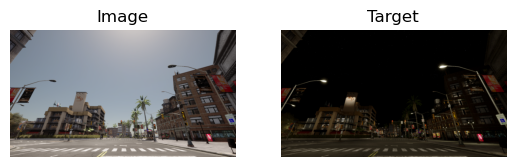

In [170]:
sample = random.randint(0, len(dataset_train))
show_sample(dataset_train,sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


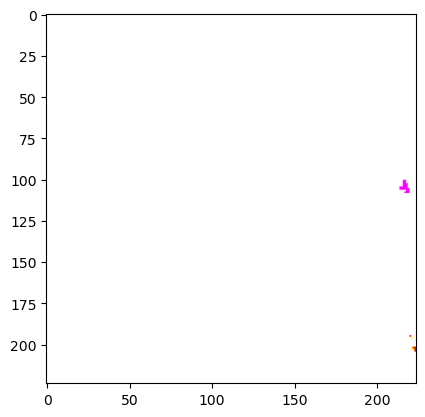

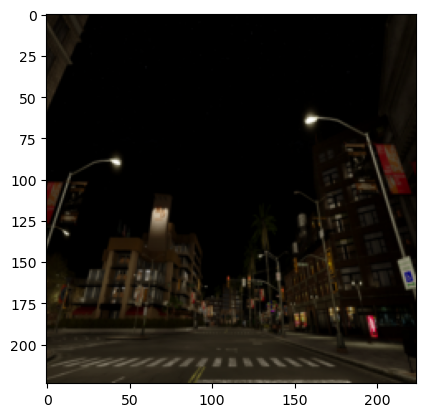

torch.Size([3, 224, 224])
tensor(-2.0357) tensor(1069.3928)


In [171]:
# code to show a rgb image of the dataset using dataset_train[sample]

def plot_tensor(tensor: torch.Tensor):
  tensor = tensor.permute(1, 2, 0)
  plt.imshow(tensor)
  plt.show()
  
plot_tensor(dataset_train[sample][0])
plot_tensor(dataset_train[sample][1])
print(dataset_train[sample][0].shape)
print(dataset_train[sample][0].min(), dataset_train[sample][0].max())

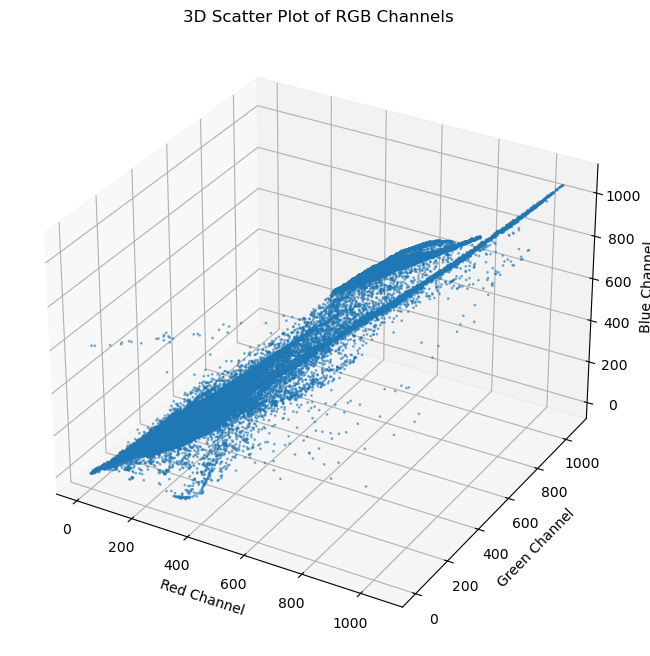

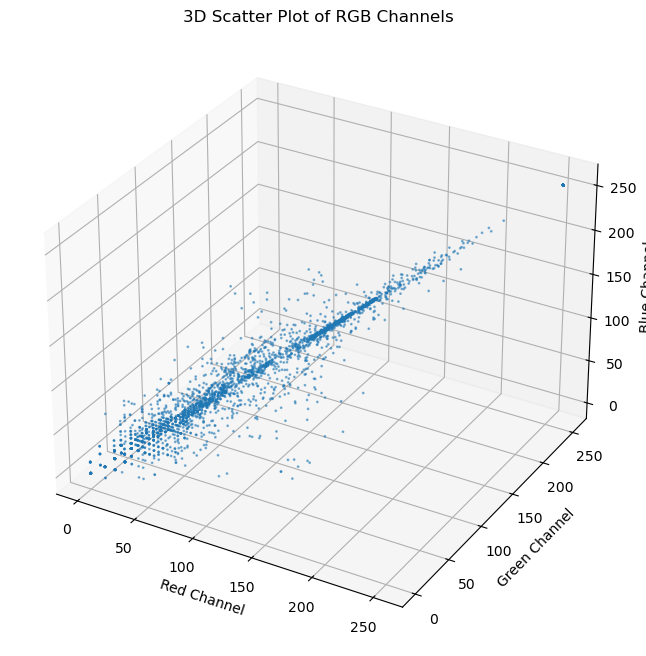

In [172]:
def scatter_plot_three_channels(rgb_image):
    """
    Create a 3D scatter plot of the RGB channels of an image.

    Parameters:
    - rgb_image: A tensor or NumPy array of shape (C, H, W) or (H, W, C).
    """

    if isinstance(rgb_image, torch.Tensor):
        rgb_image = rgb_image.numpy()
        if rgb_image.shape[0] == 3:  
            rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Convert to (H, W, C)

    # Flatten the channels
    r_values = rgb_image[..., 0].flatten()  # Red channel
    g_values = rgb_image[..., 1].flatten()  # Green channel
    b_values = rgb_image[..., 2].flatten()  # Blue channel

    # Create 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(r_values, g_values, b_values, alpha=0.5, s=1)  # Set size of points to 1 for clarity

    ax.set_title('3D Scatter Plot of RGB Channels')
    ax.set_xlabel('Red Channel')
    ax.set_ylabel('Green Channel')
    ax.set_zlabel('Blue Channel')
    
    plt.show()

# Example usage
scatter_plot_three_channels(dataset_train[sample][0])
scatter_plot_three_channels(read_image(dataset_train.img_labels.iloc[sample, 0]))


# Model

we gonna build up a U-Net using a pretrained resnet18 as encoder :)

In [173]:
resnet18 = torchvision.models.resnet18(pretrained=True)
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18

/home/lautaro-fernandez/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lautaro-fernandez/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [174]:
for i,layer in enumerate(list(resnet18.children())[:-2]):
  print('=======================================')
  print('BLOCK', i)
  print(layer)

BLOCK 0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BLOCK 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BLOCK 2
ReLU(inplace=True)
BLOCK 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BLOCK 4
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3),

In [175]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        self.resnet = resnet18
        self.encoder_layers = list(self.resnet.children())[:-2]  # no avgpool nor fc
        self.encoder_block0 = nn.Sequential(*self.encoder_layers[:4])  # kind of init
        self.encoder_block1 = self.encoder_layers[4]                   
        self.encoder_block2 = self.encoder_layers[5]                   
        self.encoder_block3 = self.encoder_layers[6]                   
        self.encoder_block4 = self.encoder_layers[7]         
    
    def forward(self, x):
        print('gradients: ',torch.is_grad_enabled())
        x0 = self.encoder_block0(x) 
        x1 = self.encoder_block1(x0)  
        x2 = self.encoder_block2(x1)  
        x3 = self.encoder_block3(x2)  
        x4 = self.encoder_block4(x3)  
        return x0, x1, x2, x3, x4

class ResNetDecoder(nn.Module):
    def __init__(self):
        super(ResNetDecoder, self).__init__()
        def _upconv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        # decoder
        self.upconv4 = _upconv_block(512, 256)
        self.upconv3 = _upconv_block(512, 128)
        self.upconv2 = _upconv_block(256, 64)
        self.upconv1 = _upconv_block(128, 64)

        # x0 must match d1 shape
        self.upconv0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        # final upconv
        self.upconv = _upconv_block(64, 64)
    def forward(self, X):
        print('gradients: ',torch.is_grad_enabled())
        x0, x1, x2, x3, x4 = X
        d4 = self.upconv4(x4)  
        d3 = self.upconv3(torch.cat((d4,x3),dim=1))
        d2 = self.upconv2(torch.cat((d3,x2),dim=1))
        d1 = self.upconv1(torch.cat((d2,x1),dim=1))
        x0_up = self.upconv0(x0)
        d0 = self.upconv(torch.cat((d1,x0_up)))
        return d0


In [176]:
class ResNetUNet(nn.Module):
    def __init__(self):
        super(ResNetUNet, self).__init__()            
        self.encoder = ResNetEncoder()
        self.decoder = ResNetDecoder()
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
            print('encoder output')
            for i in x:
                print(i.shape)
        x = self.decoder(x)
        print('decoder output')
        print(x.shape)
        x = self.final_conv(x)
        print('final output')
        print(x.shape)
        return x

In [177]:
net = ResNetUNet()
net(dataset_train[sample][0].unsqueeze(0)).shape

gradients:  False
encoder output
torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])
gradients:  True
decoder output
torch.Size([2, 64, 224, 224])
final output
torch.Size([2, 3, 224, 224])


torch.Size([2, 3, 224, 224])